# CodeGen parameter

In [49]:
import org.apache.spark.sql.internal.SQLConf.WHOLESTAGE_CODEGEN_ENABLED
spark.conf.get(WHOLESTAGE_CODEGEN_ENABLED.key)

import org.apache.spark.sql.internal.SQLConf.WHOLESTAGE_CODEGEN_ENABLED
res24: String = true


In [44]:
spark.sessionState.conf.wholeStageEnabled

res19: Boolean = true


# whole stage code gen by rule

In [11]:
val q = spark.range(10).groupBy('id % 2 as "gid").count()
q.show()

+---+-----+
|gid|count|
+---+-----+
|  0|    5|
|  1|    5|
+---+-----+



q: org.apache.spark.sql.DataFrame = [gid: bigint, count: bigint]


# 对比 SparkPlan 和 executedPlan

In [17]:
q.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[(id#31L % 2)#51L], functions=[count(1)])
+- Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
   +- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)])
      +- *(1) Range (0, 10, step=1, splits=4)




In [29]:
val sparkPlan = q.queryExecution.sparkPlan

sparkPlan: org.apache.spark.sql.execution.SparkPlan =
HashAggregate(keys=[(id#31L % 2)#51L], functions=[count(1)], output=[gid#33L, count#36L])
+- HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
   +- Range (0, 10, step=1, splits=4)


In [30]:
val executedPlan = q.queryExecution.executedPlan

executedPlan: org.apache.spark.sql.execution.SparkPlan =
*(2) HashAggregate(keys=[(id#31L % 2)#51L], functions=[count(1)], output=[gid#33L, count#36L])
+- Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
   +- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
      +- *(1) Range (0, 10, step=1, splits=4)


In [64]:
executedPlan.children.head.children.head.children

res35: Seq[org.apache.spark.sql.execution.SparkPlan] =
List(Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
+- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
   +- *(1) Range (0, 10, step=1, splits=4)
)


In [63]:
executedPlan.children.head.children

res34: Seq[org.apache.spark.sql.execution.SparkPlan] =
List(Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
+- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
   +- *(1) Range (0, 10, step=1, splits=4)
)


In [25]:
import org.apache.spark.sql.execution.CollapseCodegenStages
val ccsRule = CollapseCodegenStages(spark.sessionState.conf)


import org.apache.spark.sql.execution.CollapseCodegenStages
ccsRule: org.apache.spark.sql.execution.CollapseCodegenStages = CollapseCodegenStages(org.apache.spark.sql.internal.SQLConf@2d4b544,0)


In [31]:
val planAfterCCS = ccsRule(sparkPlan)

planAfterCCS: org.apache.spark.sql.execution.SparkPlan =
*(3) HashAggregate(keys=[(id#31L % 2)#51L], functions=[count(1)], output=[gid#33L, count#36L])
+- *(3) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
   +- *(3) Range (0, 10, step=1, splits=4)


In [32]:
// The number of stage IDs do not match
// Looks like the above misses one or more rules
// EnsureRequirements optimization rule?
// It is indeed executed before CollapseCodegenStages
import org.apache.spark.sql.execution.exchange.EnsureRequirements
val erRule = EnsureRequirements(spark.sessionState.conf)
val planAfterER = erRule.apply(sparkPlan)

import org.apache.spark.sql.execution.exchange.EnsureRequirements
erRule: org.apache.spark.sql.execution.exchange.EnsureRequirements = EnsureRequirements(org.apache.spark.sql.internal.SQLConf@2d4b544)
planAfterER: org.apache.spark.sql.execution.SparkPlan =
HashAggregate(keys=[(id#31L % 2)#51L], functions=[count(1)], output=[gid#33L, count#36L])
+- Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#64]
   +- HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
      +- Range (0, 10, step=1, splits=4)


In [34]:
val planAfterCCS = ccsRule(planAfterER)

planAfterCCS: org.apache.spark.sql.execution.SparkPlan =
*(7) HashAggregate(keys=[(id#31L % 2)#51L], functions=[count(1)], output=[gid#33L, count#36L])
+- Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#72]
   +- *(6) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
      +- *(6) Range (0, 10, step=1, splits=4)


In [36]:
assert(planAfterCCS == q.queryExecution.executedPlan, "Plan after ER and CCS rule should match the executed plan")

# executedPlan

In [40]:
import org.apache.spark.sql.execution.WholeStageCodegenExec
val wsce = executedPlan.asInstanceOf[WholeStageCodegenExec]

import org.apache.spark.sql.execution.WholeStageCodegenExec
wsce: org.apache.spark.sql.execution.WholeStageCodegenExec =
*(2) HashAggregate(keys=[(id#31L % 2)#51L], functions=[count(1)], output=[gid#33L, count#36L])
+- Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
   +- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
      +- *(1) Range (0, 10, step=1, splits=4)


In [41]:
// The single child operator should be HashAggregateExec
import org.apache.spark.sql.execution.aggregate.HashAggregateExec
val hae = wsce.child.asInstanceOf[HashAggregateExec]

import org.apache.spark.sql.execution.aggregate.HashAggregateExec
hae: org.apache.spark.sql.execution.aggregate.HashAggregateExec =
HashAggregate(keys=[(id#31L % 2)#51L], functions=[count(1)], output=[gid#33L, count#36L])
+- Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
   +- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
      +- *(1) Range (0, 10, step=1, splits=4)


In [42]:
// Since ShuffleExchangeExec does not support codegen, the child of HashAggregateExec is InputAdapter
import org.apache.spark.sql.execution.InputAdapter
val ia = hae.child.asInstanceOf[InputAdapter]

import org.apache.spark.sql.execution.InputAdapter
ia: org.apache.spark.sql.execution.InputAdapter =
Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
+- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
   +- *(1) Range (0, 10, step=1, splits=4)


In [43]:
// And it's only now when we can get at ShuffleExchangeExec
import org.apache.spark.sql.execution.exchange.ShuffleExchangeExec
val se = ia.child.asInstanceOf[ShuffleExchangeExec]

import org.apache.spark.sql.execution.exchange.ShuffleExchangeExec
se: org.apache.spark.sql.execution.exchange.ShuffleExchangeExec =
Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
+- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
   +- *(1) Range (0, 10, step=1, splits=4)


# InputAdapter

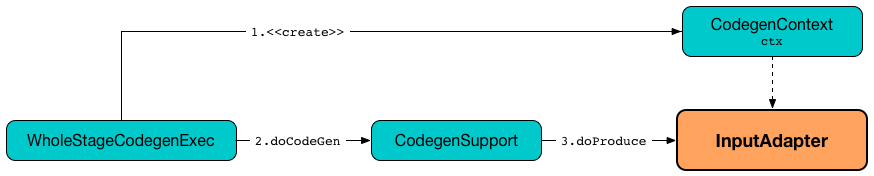

In [54]:
// Find all InputAdapters in the physical query plan
import org.apache.spark.sql.execution.InputAdapter
val adapters = executedPlan.collect{ case a:InputAdapter => a}
adapters.zipWithIndex.map{ case (op, idx) => s"$idx) $op"}.foreach(println)

0) Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
+- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
   +- *(1) Range (0, 10, step=1, splits=4)



import org.apache.spark.sql.execution.InputAdapter
adapters: Seq[org.apache.spark.sql.execution.InputAdapter] =
ArrayBuffer(Exchange hashpartitioning((id#31L % 2)#51L, 200), true, [id=#57]
+- *(1) HashAggregate(keys=[(id#31L % 2) AS (id#31L % 2)#51L], functions=[partial_count(1)], output=[(id#31L % 2)#51L, count#47L])
   +- *(1) Range (0, 10, step=1, splits=4)
)


In [58]:
import org.apache.spark.sql.catalyst.expressions.codegen.CodegenContext
val ctx = new CodegenContext

import org.apache.spark.sql.execution.CodegenSupport

val code = adapters.head.produce(ctx, executedPlan.asInstanceOf[CodegenSupport])
println(code)




 while ( inputadapter_input_0.hasNext()) {
   InternalRow inputadapter_row_0 = (InternalRow) inputadapter_input_0.next();
   
   append(inputadapter_row_0);
   if (shouldStop()) return;
 }
     
     


import org.apache.spark.sql.catalyst.expressions.codegen.CodegenContext
ctx: org.apache.spark.sql.catalyst.expressions.codegen.CodegenContext = org.apache.spark.sql.catalyst.expressions.codegen.CodegenContext@359f78f5
import org.apache.spark.sql.execution.CodegenSupport
code: String =
"


 while ( inputadapter_input_0.hasNext()) {
   InternalRow inputadapter_row_0 = (InternalRow) inputadapter_input_0.next();

   append(inputadapter_row_0);
   if (shouldStop()) return;
 }

     "
